####  pyTorch를 비롯해  필요한 라이브러리를 읽어온다.


In [0]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as vision_dsets
import torchvision.transforms as transforms
from torch import optim
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

### Hyper-parameter 세팅 및 기타 변수 지정
1. gpu에서 사용하기 위해 cuda 설정하여 device에 저장
2. parameter 설정하기

gpu(cuda)가 사용 가능한지 확인하는 메서드

In [0]:
torch.cuda.is_available()

True

사용할 device를 device 변수에 저장해놓기

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr  = learning rate : back propagation 할 때 cost function 에서 최적점 찾아갈 때 사용 경험상 0.001정도가 적당하다.
- 너무 크면 발산한다.
- 작으면 너무 오래 걸리는 문제가 발생한다.

batch_size : 벡터 하나씩 넣으면 너무 오래 걸리므로 batch_size를 정해서 여러개 벡터를 한 번에 넣어준다.

best_acc = best test accuracy : 가장 좋은 정확도

start_epoch = 0 : 시작 epoch 맨 처음은 0 check point있다면 check point부터

In [0]:
lr = 0.001 # learning rate
batch_size = 128 # batch_size : 벡터 하나씩 넣으면 너무
best_acc = 0
start_epoch = 0

### 다양한 함수 연습

In [0]:
# torch.view 연습

sample = torch.randn(2000, 3, 64, 64) # batch, chanel, height, width

B, C, H, W = sample.size() # torch의 size()는 torch의 모양을 돌려준다.

sample1 = sample.view(B,-1) # (2000, 3*64*64) flat한 vector로 만들어주기

print(sample1.size())

torch.Size([2000, 12288])


위 sample1을 (2000\*3, 64\*64) 로 바꿔보자

In [0]:
sample2 = sample1.view(B*C, -1)
print(sample2.size())

torch.Size([6000, 4096])


torch.view 연습 예제
- FloatTensor(a,b,c) : tensor는 기본적으로 3차원을 말한다. FloatTensor는 dtype이 float인 cpu tensor

In [0]:
a = torch.FloatTensor(5, 20, 100)
a1 = a.view(2, 10, -1)
print(a1.size())
a2 = a.view(-1, 10, 200)
print(a2.size())

torch.Size([2, 10, 500])
torch.Size([5, 10, 200])


dimension 간의 사이즈 이동이 가능하다.

In [0]:
sample = torch.randn(2000, 3, 32, 64)

0, 1, 2, 3 -> 0, 1, 3, 2 -> 2와 3의 위치를 바꾸고 싶을 때 다음 permute 메서드를 사용하여 바꿀 수 있다.

In [0]:
sample1 = sample.permute(0,1,3,2)

In [0]:
print(sample.size())
print(sample1.size())

torch.Size([2000, 3, 32, 64])
torch.Size([2000, 3, 64, 32])


sample1의 dimension을 원래대로 돌리고 싶다면?

In [0]:
sample2 = sample1.permute(0,1,3,2)

In [0]:
# torch.equal은 torch의 size가 같고 element가 같으면 True를 반환
# 그 이외의 것들은 모두 False
print(torch.equal(sample, sample2))

True


### Convolution layer

torch.nn.conv 연습하기
- nn.Conv2d(in, out, filter_size, stride, padding)
- output size가 (16, 128, 32, 32)가 되도록 해봅시다

In [0]:
input1 = torch.zeros(16, 3, 64, 64) # input으로 들어갈 torch.Tensor
conv1 = nn.Conv2d(3, 512, 3, 1, 1) # 16,3,64,64 -> 16, 512, 64, 64 
conv2 = nn.Conv2d(512, 128, 4, 2, 1)# 16, 512, 64, 64 -> 16, 128, 32, 32

In [0]:
out = conv1(input1)
print(out.size())

torch.Size([16, 512, 64, 64])


In [0]:
output = conv2(out)
print(output.size())

torch.Size([16, 128, 32, 32])


torch.nn.conv 연습2
- nn.Conv2d(in, out, filter_size, stride, padding)
- output size가 (16, 512, 16, 16)이 되도록 해봅시다

In [0]:
input2 = torch.zeros(16,3,64,64)
conv1 = nn.Conv2d(3, 64, 3, 1, 1) # 16,3,64,64 -> 16,64,64,64
conv2 = nn.Conv2d(64, 512, 3, 4, 1) # 16,64,32,32 -> 16,512,16,16

out = conv1(input2)
output = conv2(out)

print(out.size())
print(output.size())

torch.Size([16, 64, 64, 64])
torch.Size([16, 512, 16, 16])


torch.nn.conv 연습3
- nn.Conv2d(in, out, filter_size, stride, padding)
- output size가 (16, 512, 64, 64)이 되도록 해봅시다

In [0]:
input3 = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3, 64, 3, 1, 1)
conv2 = nn.Conv2d(64, 512, 3, 1, 1)

out = conv1(input3)
output = conv2(out)

print(out.size())
print(output.size())

torch.Size([16, 64, 64, 64])
torch.Size([16, 512, 64, 64])


### 데이터 로딩
#### 연습 데이터를 불러와서 전처리를 거쳐 학습 시켜봅시다.

> Data Augmentation은 CNN의 성능을 향상시키기 위해 사용하는 기법이다. 이미지를 여러 방법을 통해 변형 시켜서 입력 이미지로 사용하는 방식이다. 이와 같은 방법을 사용하는 이유는 모든 픽셀을 1칸씩 이동 시켰을 때 사람은 똑같이 인식하지만 컴퓨터 입장에서는 원본 이미지와 다른 것으로 인식하게 된다. 이를 해결하기 위해 data augmentation을 사용한다. 다시말해 이미지 레이블을 변경하지 않고 픽셀을 변화시키는 방법이다.

트레인셋 전처리 transform

In [0]:
print('==> Preparing data...')

transform_train = transforms.Compose([ # 여러개의 transforms를 조립 list형으로 transform 전달 
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을줘서 32x32로 random cropping(랜덤으로 자르기?)
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지를 반전하여 넣어준다.
    transforms.ToTensor(),
    # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data...


랜덤 cropping을 하고 이미지 좌우 반전을 해주는 이유는??? ex) 고양이
![대체 텍스트](https://t1.daumcdn.net/cfile/tistory/99F718445B62CED001)
- 좌우 반전을 시키는 이유는 왼쪽을 바라보는 고양이만 넣어주게되면  오른쪽을 바라보는 고양이를 못 맞추게 된다. 좌우 반전된 사진을 섞어서 인풋으로 넣어주면 고양이가 어느쪽을 바라보더라도 맞추게 된다.

![대체 텍스트](https://t1.daumcdn.net/cfile/tistory/9959F23A5B62CED111)
- 이미지를 잘라주는 이유는 고양이가 상자 속에 들어가서 꼬리만 있는 사진을 사람은 꼬리를 보고 고양이라고 판단할 수 있으나 딥러닝은 상자까지 인식해서 고양이의 특징을 제대로 파악 못한다. 사람이 인식하는 방법을 모방하기 위해 부분부분 잘라서 넣어주면 각 부분만 보고도 고양이라고 반단할 수 있다.

테스트 데이터 전처리 transform

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#### 데이터 로딩

In [0]:
# torchvision.datasets.CIFAR10: CIFAR10 데이터셋 불러오기
# root : 데이터 셋이 있는 경로, train=True : trainset으로 불러오기 Fasle면 test set
# download: True면 dataset을 인터넷에서 받아와서 경로에 넣어준다.
# transform: transform/function을 넣어주면 이미지를 이에 따라 변환시켜준다.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# python iterable로 만들어주는애 = torch.utils.data.DataLoader
# shuffle=True : 매 epoch마다 reshuffle한다.
# num_workers는 데이터 로딩에 사용되는 subprocess 개수를 정해주는 애 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1) 
print(trainloader.dataset.data.shape)

Files already downloaded and verified
(50000, 32, 32, 3)


In [0]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False,num_workers=1 )

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### 이미지 학습시키기

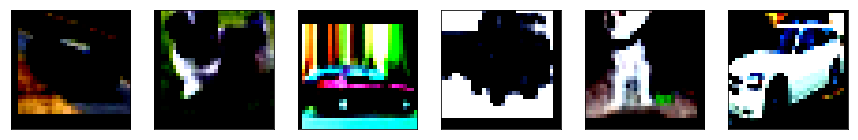

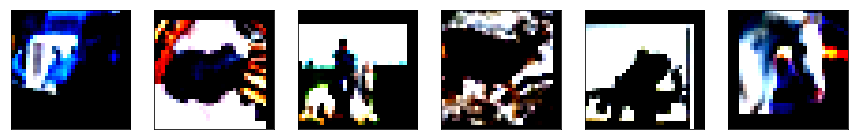

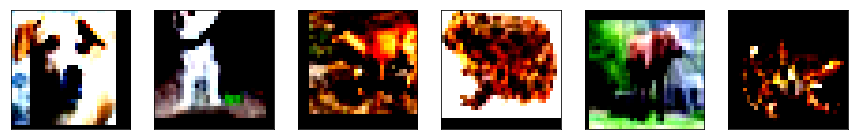

In [0]:
def showImages(image, row):
    for _ in range(row):
        idx = np.random.choice(batch_size, 6) # 0 ~ 127의 정수 중 6개를 임의로 선택
        images = image.numpy()[idx].transpose(0,2,3,1).clip(0,1) # 선택된 indexㅇ 해당하는 이미지를 가져온다.
        plt.figure(figsize=(15,90)) # 세로 길이 15, 가로길이 15 * 6 의 화면 생성
        
        # 1줄에 6개 보여주니까 6개 출력
        for i in range(161, 167):
            plt.subplot(i)
            plt.imshow(images[i - 161])
            plt.xticks([])
            plt.yticks([])
            
        plt.show() # 1줄 보여주기
        
for i, (image, labels) in enumerate(trainloader):
    showImages(image.squeeze(), 3)
    break

In [0]:
# 미니 배치가 몇개가 있는지
print('[info] # of train batch :', len(trainloader)) 
print('[info] # of test batch: ', len(testloader))

[info] # of train batch : 391
[info] # of test batch:  100


### 학습 신경망 구현

net, optimizer, trainloader, epochs

epochs : 학습 반복 횟수

optimizer : 최적화 방법

trainloader : 학습 데이터

net: 뉴럴 넷

In [0]:
def train_network(net, optimizer, trainloader, epochs=5):
    for epoch in range(epochs):
        
        running_loss = 0.0 # running_loss : target과 label의 score들의 합
        for i, data in enumerate(trainloader):
            inputs, labels = data
            
            # gpu로 올려서 학습 진행한다.
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 현재의 backprop을 계산하기 위해서 저장했던 activation buffer를 비워준다.
            optimizer.zero_grad()
            
            # input을 network에 넣어서 결과를 얻어낸다.
            outputs = net(inputs)
            
            # loss function에 주어진 target과 labels를 넣으면 score를
            # 계산하여 반환
            # 여기서 criterion은 CrossEntropyLoss가 사용되었음.
            # 후에 정의함 왜 후에 정의하는지는 모르겠음.
            # criterion(input, target)
            loss = criterion(outputs, labels) 
            
            # 주어진 loss 값을 바탕으로 backpropagation이 진행된다.
            # sum of gradients of given tensors w.r.t graph leaves
            loss.backward()
            
            # 계산된 Backprop을 바탕으로 gradient descending을 수행한다.
            # 파라미터를 업데이트 시켜준다.
            optimizer.step() 
            
            running_loss += loss.item()
            # print every 500 mini-batches
            if (i+1) % 100 == 0:
                print('[%d, %5d] loss: %.3f' %
                     (epoch+1, i+1, running_loss / 100))
                running_loss = 0.0
    
    print('Finished Training')
            

테스트를 실행하는 함수 만들기

In [0]:
def test(model, test_loader):
    # 학습을 시키지 않는 테스트 모드로 사용하겠다고 선언한 것
    # Dropout, BatchNorm등 train모드가 아니고 eval모드로 작동. 
    model.eval()
    test_loss = 0 # 테스트의 loss값
    correct = 0 # 정확도
    
    for data, target in test_loader:
        # gpu로 이동해서 작업한다.
        data = data.to(device) 
        target = target.to(device)
        
        # 학습된 모델에 테스트 데이터를 넣는다.
        output = model(data)
        
        #결과의 예측 결과중 가장 높은 확률인것을 받는다.
        # output은 10개 클래드들에 대해 energies를 반환하기 때문에
        # 그 중에서 가장 높은 값이 제일 정확하므로 max를 사용한다.
        pred = output.max(1, keepdim=True)[1]
        
        # target과 같은 pred의 예측결과 값들을 합한다.
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    # ?????
    test_loss /= len(test_loader.dataset)
    print("test_loss:", test_loss)
    print("\nTest set: Accuracy: {}/{} ({:.0f}%)\n".format(
        correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

모델 파라미터 개수를 리턴하는 함수

In [0]:
def count_parameters(model):
    print('model.parameters() = ', model.parameters())
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### MNIST에 사용한 MLP를 적용

nuralnetwork는 꼭 torch.nn.Module을 상속시켜준다.

\_\_init__, forward를 오버라이딩 해준다.

In [0]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        # 파이썬 문법상 해줘야한다.
        super(MNIST_Net, self).__init__()
        
        # layer들은 순서가 중요하므로 sequential 인 list에다가 순서대로 저장한다.
        layer_list = [] 
        # 들어오는 학습 데이터가 transform에 의하여 32*32사이즈로 들어오므로 크기를 맞춰준다.
        layer_list.append(nn.Linear(3*32*32, 256))
        
        # spatial을 다 없애서 1d를 사용한다.
        # BatchNorm을 해주는 이유
        # -> regularization(정규화)을 해줘서 학습의 효율을 높여준다.
        #    학습 속도가 개선되고, 가중치 초기값 선택의 의존성이 적어진다.
        #    overfitting의 이험을 줄일 수 있다
        #    Gradient Vanishing 문제(기울기값이 0이되는 문제)를 해결할 수 있다.
        layer_list.append(nn.BatchNorm1d(256))
        layer_list.append(nn.ReLU())
        
        #Layer2
        layer_list.append(nn.Linear(256, 64))
        layer_list.append(nn.BatchNorm1d(64))
        layer_list.append(nn.ReLU())
        
        #Layer3
        layer_list.append(nn.Linear(64, 10))
        
        # nn.Sequential에 layer_list를 넘겨준다.
        self.net = nn.Sequential(*layer_list)
        
       
    def forward(self, x):
        # 기존의 128(B), 3(C), 32(H), 32(W) 를 일자로 쭉 늘려준다.
        x = x.view(-1, 32*32*3) 
        x = self.net(x) # net에 넣어주면 계산
        return x

In [0]:
# 뉴럴 네트워크를 인스턴스화 해서 빠른 학습을 위해 gpu에 올려준다.
mnist_net = MNIST_Net().to(device)
# loss function을 정의해준다. cross entrophy loss 사용
# continuous한 값에는 MSE, L1, L2 loss function을 사용하는 것이 좋다.
criterion = nn.CrossEntropyLoss()
# optimizer 정의
# training할 파라미터와 learning rate를 인자로 준다.
# Adam(A Method for Stochastic Optimization) stochastic -> 모집단에서 임의로 추출한 표본에 따라 모집단의 상태를 추측
optimizer = optim.Adam(mnist_net.parameters(), lr=lr)

In [0]:
train_network(mnist_net, optimizer, trainloader)

[1,   100] loss: 2.020
[1,   200] loss: 1.828
[1,   300] loss: 1.739
[2,   100] loss: 1.656
[2,   200] loss: 1.629
[2,   300] loss: 1.602
[3,   100] loss: 1.556
[3,   200] loss: 1.562
[3,   300] loss: 1.545
[4,   100] loss: 1.518
[4,   200] loss: 1.509
[4,   300] loss: 1.501
[5,   100] loss: 1.486
[5,   200] loss: 1.485
[5,   300] loss: 1.468
Finished Training


In [0]:
test(mnist_net, testloader)

test_loss: 0.0

Test set: Accuracy: 5018/10000 (50%)



## 심플한 CNN 모델 만들기
<구성>

Layer 1 - input: 3 x 32 x 32, output: 64 x 32 x 32- ReLU + BatchNorm

Layer 2 - input: 64 x 32 x 32, output: 128 x 16 x 16- ReLU + BatchNorm (Down Conv라고 부릅니다.)

Layer 5 - Global Average Pooling (128 x 16 x 16 => 128 x 1 x 1)

Layer 6 - input: 128 x 1 x 1, output 10 x 1 x 1 - ReLU + BatchNorm

![대체 텍스트](https://cdn-images-1.medium.com/max/1600/1*D47ER7IArwPv69k3O_1nqQ.png)

In [0]:
class DiyCNN(nn.Module):
    def __init__(self):
        super(DiyCNN, self).__init__()
        
        layers = []
        
        # Layer1
        # (128, 3, 32, 32) -> (128, 64, 32, 32)
        # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
        # F = 3 p = 1
        # F = 5 p = 2
        # F = 7 p = 3
        layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)]
        # 앞선 MLP 시간과 달리 spatial resolution(공간 해상도)이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
        layers += [nn.BatchNorm2d(64)]
        layers += [nn.ReLU()]
        
        # Layer2
        # (128, 64, 32, 32) => (128, 128, 16, 16)
        layers += [nn.Conv2d(64, 128, 3, 2, 1)]
        layers += [nn.BatchNorm2d(128)]
        layers += [nn.ReLU()]
        
        # Layer3
        # (B, 128, 16, 16) => (B, 256, 8, 8)
        layers += [nn.Conv2d(128, 256, 3, 2, 1)]
        layers += [nn.BatchNorm2d(256)]
        layers += [nn.ReLU()]
        
        # Layer4
        # (B, 256, 8, 8) => (B, 512, 4, 4)
        layers += [nn.Conv2d(256, 512, 3, 2, 1)]
        layers += [nn.BatchNorm2d(512)]
        layers += [nn.ReLU()]
        
        #Layer 5 
        # Global Average Pooling (128 x 16 x 16 => 128 x 1 x 1)
        layers += [nn.AdaptiveAvgPool2d(1)] # 1 -> (-1,1) -> (512, 1) 

        # Layer 6 
        # input: 128 x 1 x 1, output 10 x 1 x 1 - ReLU + BatchNorm
        layers += [nn.Conv2d(512, 10, 1, 1, 0)]
        
        
        self.main = nn.Sequential(*layers)
       
    
    def forward(self, x):
        out = self.main(x)
        return out.squeeze(3).squeeze(2)
        
        
        

In [0]:
cifar_net = DiyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_net.parameters(), lr=lr)

print('[info] number of model parameter - %d' %(count_parameters(cifar_net)))

model.parameters() =  <generator object Module.parameters at 0x7fe7dacc7ba0>
[info] number of model parameter - 1558026


In [0]:
train_network(cifar_net, optimizer, trainloader)

[1,   100] loss: 1.731
[1,   200] loss: 1.476
[1,   300] loss: 1.358
[2,   100] loss: 1.191
[2,   200] loss: 1.143
[2,   300] loss: 1.095
[3,   100] loss: 1.030
[3,   200] loss: 1.003
[3,   300] loss: 0.964
[4,   100] loss: 0.916
[4,   200] loss: 0.913
[4,   300] loss: 0.896
[5,   100] loss: 0.855
[5,   200] loss: 0.824
[5,   300] loss: 0.841
Finished Training


In [0]:
test(cifar_net, testloader)

test_loss: 0.0

Test set: Accuracy: 7167/10000 (72%)



### Average Pooling대신 Linear Layer를 사용하여 비교해보자.

average pooling parameter개수 = 1,558,026

linear layer parameter 개수 = 2,614,794


성능은 비슷하다 

Linear Layer가 paramter를 많이 차지하므로 더 무겁다.

Aveage Pooling이 더 가벼워서 많이 사용한다.


In [0]:
class DiyCNN(nn.Module):
    def __init__(self):
        super(DiyCNN, self).__init__()
        
        layers = []
        
        # Layer1
        # (128, 3, 32, 32) -> (128, 64, 32, 32)
        layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)]
        # 앞선 MLP 시간과 달리 spatial resolution(공간 해상도)이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
        layers += [nn.BatchNorm2d(64)]
        layers += [nn.ReLU()]
        
        # Layer2
        # (128, 64, 32, 32) => (128, 128, 16, 16)
        layers += [nn.Conv2d(64, 128, 3, 2, 1)]
        layers += [nn.BatchNorm2d(128)]
        layers += [nn.ReLU()]
        
        # Layer3
        # (B, 128, 16, 16) => (B, 256, 8, 8)
        layers += [nn.Conv2d(128, 256, 3, 2, 1)]
        layers += [nn.BatchNorm2d(256)]
        layers += [nn.ReLU()]
        
        # Layer4
        # (B, 256, 8, 8) => (B, 512, 4, 4)
        layers += [nn.Conv2d(256, 512, 3, 2, 1)]
        layers += [nn.BatchNorm2d(512)]
        layers += [nn.ReLU()] # B X 512*4 -> 128 X 512
        
        # classifier
        classifier = []
        classifier += [nn.Linear(512*4, 512)]
        
        classifier += [nn.Linear(512, 10)]
        
        
        self.main = nn.Sequential(*layers)
        self.classifier = nn.Sequential(*classifier)
       
    
    def forward(self, x):
        out = self.main(x) # 128, 512, 2, 2
        out = out.view(out.size(0), -1) # 128, 152*2*2
        out = self.classifier(out)
        return out
        
        
        

In [0]:
cifar_net = DiyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_net.parameters(), lr=lr)

print('[info] number of model parameter - %d' % (count_parameters(cifar_net)))

model.parameters() =  <generator object Module.parameters at 0x7fe7daeb81a8>
[info] number of model parameter - 2607114


In [0]:
train_network(cifar_net, optimizer, trainloader)

[1,   100] loss: 1.745
[1,   200] loss: 1.508
[1,   300] loss: 1.388
[2,   100] loss: 1.217
[2,   200] loss: 1.172
[2,   300] loss: 1.104
[3,   100] loss: 1.023
[3,   200] loss: 0.988
[3,   300] loss: 0.963
[4,   100] loss: 0.911
[4,   200] loss: 0.880
[4,   300] loss: 0.866
[5,   100] loss: 0.799
[5,   200] loss: 0.801
[5,   300] loss: 0.807
Finished Training


In [0]:
test(cifar_net, testloader)

test_loss: 0.0

Test set: Accuracy: 7457/10000 (75%)



### 데이터 initialization

initialization을 하는 이유는 deep neural network 통해서 forward중에 exploding, vanishing이 일어나는 것을 예방하기 위해서다.

exploding or vanishing이 일어나게 되면 backward 과정에서 cost function이 발산하거나 너무 천천히 최적화되거나 local minimum 문제가 발생하게 된다.


In [0]:
class DiyCNN(nn.Module):
    def __init__(self):
        super(DiyCNN, self).__init__()
        
        layers = []
        
        layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)]
        layers += [nn.BatchNorm2d(64)]
        layers += [nn.ReLU()]
        
        layers += [nn.Conv2d(64, 128, 3, 2, 1)]
        layers += [nn.BatchNorm2d(128)]
        layers += [nn.ReLU()]
        
        layers += [nn.Conv2d(128, 256, 3, 2, 1)]
        layers += [nn.BatchNorm2d(256)]
        layers += [nn.ReLU()]
        
        layers += [nn.Conv2d(256, 512, 3, 2, 1)]
        layers += [nn.BatchNorm2d(512)]
        layers += [nn.ReLU()]
        
        layers += [nn.AdaptiveAvgPool2d(1)] # 1 -> (-1,1) -> (512, 1) 

        layers += [nn.Conv2d(512, 10, 1, 1, 0)]
        
        
        self.main = nn.Sequential(*layers)
        self._reset_params() # initialize 하는 부분
        
    
    # 초기 weight 설정
    # xavier 초기값 설정
    # -> 앞 layer의 입력 노드 수와 출력 노드 수를 고려하여 초기 값을 설정
    # a = gain * sqrt(6 / (fan_in + fan_out))
    # torch.nn.init.xavier_uniform_(w, gain)
    # w : weight n-dimensional torch.Tensor, gain : optional scaling factor
    def _reset_params(self):
        for i, layer in enumerate(self.main):
            if type(layer) == nn.Conv2d:
                torch.nn.init.xavier_uniform_(layer.weight.data)
       
    
    def forward(self, x):
        return self.main(x).squeeze(3).squeeze(2)
        
        
        

In [0]:
cifar_net = DiyCNN().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_net.parameters(), lr=lr)

In [0]:
train_network(cifar_net, optimizer, trainloader)

[1,   100] loss: 1.741
[1,   200] loss: 1.488
[1,   300] loss: 1.368
[2,   100] loss: 1.244
[2,   200] loss: 1.171
[2,   300] loss: 1.119
[3,   100] loss: 1.037
[3,   200] loss: 1.029
[3,   300] loss: 0.988
[4,   100] loss: 0.936
[4,   200] loss: 0.925
[4,   300] loss: 0.919
[5,   100] loss: 0.848
[5,   200] loss: 0.827
[5,   300] loss: 0.831
Finished Training


In [0]:
test(cifar_net, testloader)

test_loss: 0.0

Test set: Accuracy: 7271/10000 (73%)



### 데이터 전처리 Normalization을 없애면 어떻게 변할까?

-> 성능이 떨어진다.
> normalization(정규화)를 하지 않으면 outlier 때문에 학습 능력이 떨어지기 때문이다.

In [0]:
print('==> Preparing data...')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data...
Files already downloaded and verified
Files already downloaded and verified


In [0]:
cifar_net = DiyCNN().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_net.parameters(), lr=lr)

In [0]:
train_network(cifar_net, optimizer, trainloader)

[1,   100] loss: 1.714
[1,   200] loss: 1.486
[1,   300] loss: 1.403
[2,   100] loss: 1.248
[2,   200] loss: 1.177
[2,   300] loss: 1.130
[3,   100] loss: 1.046
[3,   200] loss: 1.025
[3,   300] loss: 0.987
[4,   100] loss: 0.931
[4,   200] loss: 0.922
[4,   300] loss: 0.905
[5,   100] loss: 0.841
[5,   200] loss: 0.826
[5,   300] loss: 0.830
Finished Training


In [0]:
test(cifar_net, testloader)

test_loss: 0.0

Test set: Accuracy: 6922/10000 (69%)



### 데이터 shuffling의 효과
무작위 sampling을 해준다.
> 학습의 방해를 줄이기 위해 순서 패턴을 지운다.

같은 데이터를 반복해서 학습하게 되면 그 순서 패턴을 학습하게 되는 문제가 발생한다.

In [0]:
print('==> Preparing data...')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data...
Files already downloaded and verified
Files already downloaded and verified


In [0]:
cifar_net = DiyCNN().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_net.parameters(), lr=lr)

In [0]:
train_network(cifar_net, optimizer, trainloader)

[1,   100] loss: 1.706
[1,   200] loss: 1.467
[1,   300] loss: 1.355
[2,   100] loss: 1.197
[2,   200] loss: 1.141
[2,   300] loss: 1.098
[3,   100] loss: 1.035
[3,   200] loss: 1.003
[3,   300] loss: 0.987
[4,   100] loss: 0.939
[4,   200] loss: 0.920
[4,   300] loss: 0.905
[5,   100] loss: 0.858
[5,   200] loss: 0.844
[5,   300] loss: 0.838
Finished Training


In [0]:
test(cifar_net, testloader)

test_loss: 0.0

Test set: Accuracy: 7150/10000 (72%)



### Learning rate scheduler를 도입합니다. 
MultiStepLR(optimizer, milestones=[a,b], gamma = c)

lr = optimizer의 lr (epoch < a)

lr = lr\*gamma (a <= epoch < b)

lr = lr\*gamma(b <= epoch)

기존의 설정으로 돌려줍니다. 

In [0]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])


# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64, 128, 3, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 3, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 3, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)]
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)]
    
    self.main = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

In [0]:
def train_network2(net, optimizer, trainloader, scheduler, epochs=5):
    for epoch in range(epochs):
        
        running_loss = 0.0
        
        for i, data in enumerate(trainloader):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                print('[%d, %5d] loss: %.3f' %
                     (epoch+1, i + 1, running_loss / 100))
                running_loss = 0.0
#                 print('learning rate : ', optimizer.param_groups[0]['lr'])
                
        scheduler.step()
        
    print('Finished Training')

In [0]:
from torch.optim.lr_scheduler import MultiStepLR

scheduler = MultiStepLR(optimizer, milestones=[2,4], gamma=0.5)
cifar_net = DiyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_net.parameters(), lr=0.01)
scheduler = MultiStepLR(optimizer, milestones=[2,4], gamma=0.5)

In [0]:
train_network2(cifar_net, optimizer, trainloader, scheduler,epochs=5)

[1,   100] loss: 1.843
learning rate :  0.01
[1,   200] loss: 1.565
learning rate :  0.01
[1,   300] loss: 1.433
learning rate :  0.01
[2,   100] loss: 1.275
learning rate :  0.01
[2,   200] loss: 1.209
learning rate :  0.01
[2,   300] loss: 1.163
learning rate :  0.01
[3,   100] loss: 1.003
learning rate :  0.005
[3,   200] loss: 0.960
learning rate :  0.005
[3,   300] loss: 0.945
learning rate :  0.005
[4,   100] loss: 0.911
learning rate :  0.005
[4,   200] loss: 0.884
learning rate :  0.005
[4,   300] loss: 0.853
learning rate :  0.005
[5,   100] loss: 0.788
learning rate :  0.0025
[5,   200] loss: 0.784
learning rate :  0.0025
[5,   300] loss: 0.769
learning rate :  0.0025
Finished Training


In [0]:
test(cifar_net, testloader)

test_loss: 0.0

Test set: Accuracy: 7451/10000 (75%)



### Pre-trained 모형 가지고 와서 성능 확인하기(Transfer Learning 관점)

In [0]:
import torchvision.models as models
# 기존에 만들어진 vgg network 을 이미지넷 데이터에 트레이닝해둔
# 파라미터를 그대로 받아온다.
vgg_model = models.vgg19_bn(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:04<00:00, 129129215.45it/s]


In [0]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
class DiyCNN(nn.Module):
    def __init__(self, vgg_model):
        super(DiyCNN, self).__init__()
        # 미리 학습된 vgg_model의 features에 있는 레이어들을 가져와서 붙여준다.
        self.pre_trained = nn.Sequential(
            *list(vgg_model.features.children()))
        
         # 기존에는 이미지넷에 학습되어있기 때문에, 
         # 이를 cifar-10 데이터셋용으로 바꿔줄 필요가 있다. 
        self.mlp = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    
    
    def forward(self, x):
        out = self.pre_trained(x)
        out = out.squeeze()
        out = self.mlp(out)
        return out
        


In [0]:
cifar_net = DiyCNN(vgg_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_net.parameters(), lr=lr)

print('[info] number of model parameter - %d'%(count_parameters(cifar_net)))

model.parameters() =  <generator object Module.parameters at 0x7fe7d82c90a0>
[info] number of model parameter - 20365002


In [0]:
train_network(cifar_net, optimizer, trainloader)

[1,   100] loss: 1.307
[1,   200] loss: 0.949
[1,   300] loss: 0.830
[2,   100] loss: 0.684
[2,   200] loss: 0.648
[2,   300] loss: 0.627
[3,   100] loss: 0.542
[3,   200] loss: 0.531
[3,   300] loss: 0.519
[4,   100] loss: 0.470
[4,   200] loss: 0.462
[4,   300] loss: 0.460
[5,   100] loss: 0.410
[5,   200] loss: 0.421
[5,   300] loss: 0.402
Finished Training


In [0]:
test(cifar_net, testloader)

test_loss: 0.0

Test set: Accuracy: 8563/10000 (86%)

